## Importing Libraries

In [63]:
import numpy as np
import pandas as pd
import sklearn
import time
import math
import statsmodels
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.layers import Dense, Activation, BatchNormalization, LSTM
import pickle
from IPython.display import display

tf.random.set_seed(0)
np.random.seed(0)

## Define Important Functions and Classes

In [2]:
def find_arange(x):
  x = np.array(x)
  return np.arange(x.size).reshape(x.shape)

In [3]:
def pairwise_diff(x):
  x = np.array(x)
  return x[1:] - x[:-1]

In [4]:
def find_outliers(values, threshold=2):
  z_scores = (values - np.mean(values)) / np.std(values)
  num_outliers = np.sum((z_scores > threshold) + (z_scores < -threshold))
  indices_no_outliers = ((z_scores < threshold) & (z_scores > -threshold)).astype(bool)
  lower = -threshold * np.std(values) + np.mean(values)
  upper = threshold * np.std(values) + np.mean(values)

  return values, indices_no_outliers, num_outliers, lower, upper

In [5]:
def synthesis(layers):
  '''
  Synthesizes the random layers as given by the parameter layers.
  @param: layers is a list of random layers, each of which are generator functions.
  '''
  time_step = 0
  while True:
    # update value
    value = 0
    # update value with no anomaly (na)
    value_na = 0
    # is there an anomaly? (generating labels)
    anomalous = False
    for i in layers:
      next_num = next(i)
      value += next_num
      if not(i.__name__ == "spike") and not(i.__name__ == "level_shift"):
        value_na += next_num
      elif next_num != 0 and i.__name__ == "spike":
        anomalous = True
    
    # update time step
    time_step += 1

    yield [time_step, float(value_na), float(value), anomalous]

def value(value):
  '''
  @param: value is y intercept.
  '''
  while True:
    yield value

def slope(slope):
  '''
  @param: slope adds a slight slope to the overall data.
  '''
  value = 0
  while True:
    yield value
    value += slope

def noise(mu, sigma):
  '''
  Generates statistical noise using mean and standard deviation.
  @param: mu is the mean of the noise.
  @param: sigma is the standard deviation of the noise.
  '''
  while True:
    yield np.random.normal(mu,sigma,(1,1))

def spike(period_mu, period_sigma, spike_mu, spike_sigma, length_mu, length_sigma):
  '''
  Provides spike anomalies to the data.
  @param: period_mu is the mean of the period between spikes.
  @param: period_sigma is the standard deviation of the period between spikes.
  @param: spike_mu is the mean of the spike magnitude.
  @param: spike_sigma is the standard deviation of the spike magnitude.
  @param: length_mu is the mean of the duration of the spike anomaly.
  @param: length_sigma is the standard deviation of the duration of the spike anomaly.
  '''
  spike = False
  value = 0
  while True:
    if spike and np.random.random() < 1 - 0.5 ** (1 / np.random.normal(length_mu,length_sigma,(1,1))): 
      value = 0
      spike = False
    if not(spike) and np.random.random() < 1 - 0.5 ** (1 / np.random.normal(period_mu,period_sigma,(1,1))):
      value += np.random.normal(spike_mu,spike_sigma,(1,1))
      spike = True
    yield value

def level_shift(period_mu, period_sigma, shift_mu, shift_sigma):
  '''
  Provides level shift anomalies to the data.
  @param: period_mu is the mean of the period between level shifts.
  @param: period_sigma is the standard deviation of the period between level shifts.
  @param: shift_mu is the mean of the shift magnitude.
  @param: shift_sigma is the standard deviation of the shift magnitude.
  '''
  value = 0
  while True:
    if np.random.random() < 1 - 0.5 ** (1 / np.random.normal(period_mu,period_sigma,(1,1))):
      value += np.random.normal(shift_mu,shift_sigma,(1,1))
    yield value

In [6]:
def pipeline(generator, num_time_steps, return_type="numpy", out_file=None):
  '''
  Pipeline is used to create a data set of synthesized random numbers based on a generator function. 
  @param: generator is the generator function which will be used to generate the synthetic data.
  @param: num_time_steps is the number of time steps the user desires to generate data for.
  @param: return_type is the return type of the synthetic data. Choices are "numpy," "list," or "pandas."
  @param: out_file is the name of the file to which this function should output the generated data.
  '''
  nums = []
  for i in range(num_time_steps):
    nums.append(next(generator))

  if return_type == "numpy":
    nums = np.array(nums)
    if out_file:
      pickle.dump(nums, open(out_file, "wb"))
  elif return_type == "pandas":
    nums = pd.DataFrame(np.array(nums), columns=["time_step", "value_na", "value", "anomalous"])
    if out_file:
      nums.to_csv(out_file)
  elif out_file:
    pickle.dump(nums, open(out_file, "wb"))

  return nums

In [7]:
def quality_score(data, time_col=None):
  try:
    if time_col:
      total_time = data[time_col].iloc[-1] - data[time_col].iloc[0]
      median_pairwise_time = np.median(pairwise_diff(data[time_col]))
      expected_points = total_time / median_pairwise_time + 1
      true_points = data.shape[0]
      quality_score = 100 * true_points / expected_points
    else:
      total_time = data.index[-1] - data.index[0]
      median_pairwise_time = np.median(pairwise_diff(data.index))
      expected_points = total_time / median_pairwise_time + 1
      true_points = data.shape[0]
      quality_score = 100 * true_points / expected_points
    return quality_score
  except:
    raise Exception("Score is undetermined because column is invalid.")

In [8]:
class TSModel():
  def __init__(self, name="lstm", num_units=4, lookback=10, pred_length=1):
    self.name = name 
    self.num_units = num_units
    self.lookback = lookback
    self.pred_length = pred_length
    self.model = self.make_model(name)
  def make_model(self, name):
    if name == "lstm":
      model = Sequential([
                    LSTM(self.num_units,input_shape=(1,self.lookback)),
                    Dense(self.pred_length),
              ])
    return model
  def fit(self, X_train, y_train, X_test=-1, y_test=-1, epochs=1000, batch_size=None, loss="mae", metrics=["mse"], optimizer="adam", print_metrics=True):
    if self.name == "lstm":
      self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
      if type(X_test)!=int and type(y_test)!=int:
        history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
      else:
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
      if print_metrics:
          history_pd = pd.DataFrame(history.history)
          history_pd = pd.DataFrame(history.history)
          plt.plot(history_pd["loss"], label="Train Set Loss")
          if type(X_test)!=int and type(y_test)!=int:
            plt.plot(history_pd["val_loss"], label="Test Set Loss")
          plt.legend()
          plt.xlabel("Epoch")
          plt.ylabel(loss)
          if type(X_test)!=int and type(y_test)!=int:
            plt.title("Train and Test Set Loss")
          else:
            plt.title("Train Set Loss")
          plt.show()
          temp = pd.DataFrame(history_pd.iloc[-1,:])
          temp.columns = ["Final Loss and Metrics"]
          display(temp)
          X = find_arange(y)
          plt.plot(X,y, label="original")
          plt.plot(X[lookback:lookback+X_train.shape[0]],pd.Series(model.predict(X_train).reshape(-1)), label="train")
          plt.plot(X[-X_lstm_test.shape[0]:],pd.Series(model.predict(X_lstm_test).reshape(-1)), label="test")
          plt.legend()
          plt.xlabel("Timestep")
          plt.ylabel("Value")
          if type(X_test)!=int and type(y_test)!=int:
            plt.title("Predictions for Train and Test Sets")
          else:
            plt.title("Predictions for Train Set")
          plt.show()
      return history
  def predict(self, X_vals):
    preds = self.model.predict(X_vals)
    return preds

## Example Workflow
### Generate Data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


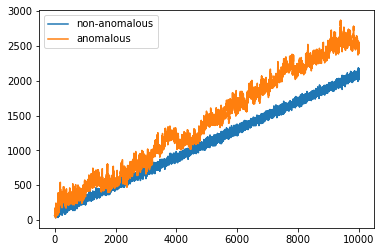

,time_step,value_na,value,anomalous,time,time_ms
0,1.0,69.981355,69.981355,0.0,2022-02-04 00:03:59.000000000,1643933039000
1,2.0,73.864202,73.864202,0.0,2022-02-04 00:22:18.559597015,1643934138559
2,3.0,62.326594,62.326594,0.0,2022-02-04 00:40:35.105405569,1643935235105
3,4.0,137.304370,137.304370,0.0,2022-02-04 00:58:53.535905123,1643936333535
4,5.0,108.642649,108.642649,0.0,2022-02-04 01:17:24.785188675,1643937444785
...,...,...,...,...,...,...
9995,9996.0,2106.420931,2484.716227,0.0,2022-06-11 06:10:20.411187172,1654927820411
9996,9997.0,2107.230992,2485.526288,0.0,2022-06-11 06:28:50.528709412,1654928930528
9997,9998.0,2174.681964,2552.977261,0.0,2022-06-11 06:46:51.949365616,1654930011949
9998,9999.0,2130.918775,2509.214071,0.0,2022-06-11 07:05:27.558399200,1654931127558


In [34]:
# Generator for synthetic data
generator = synthesis([
    value(100), 
    slope(0.2), 
    noise(0, 5), 
    noise(0, 10), 
    noise(0, 20),
    noise(0, 20),
    spike(100,10,100,10,10,2),
    spike(100,10,100,10,10,2),
    spike(100,10,100,10,10,2),
    spike(100,10,100,10,10,2),
    level_shift(100,10,50,10),
    level_shift(100,10,-50,10)
])

np.random.seed(1) # Seed
num_examples = 10000 # Number of examples
df = pipeline(generator, num_examples, return_type="pandas", out_file="nums.csv") # Synthesize data
# Make time column
time_col = [int(time.time())]
for i in range(len(df["time_step"])-1):
  time_col.append(time_col[-1] + max(1, 1000 + np.random.normal(100, 10)))
df["time"] = [pd.Timestamp(i, unit='s') for i in time_col]
df["time_ms"] = np.array(df["time"].astype(np.int64) / 10**6, np.int64)

# Plot anomalous and non-anomalous data
plt.plot(df.iloc[:,0], df.iloc[:,1], label="non-anomalous")
plt.plot(df.iloc[:,0], df.iloc[:,2], label="anomalous")
plt.legend()
plt.show()
df

### Data Quality Control

In [10]:
# Quality Score
# 100 * true_points / expected_points
print(quality_score(df, "time"))

99.99603225815996


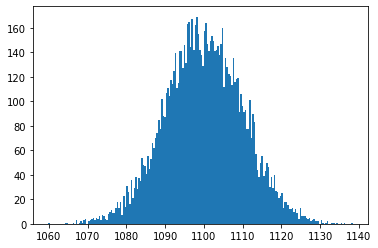

In [11]:
# Pairwise differencing histogram
_ = plt.hist(pairwise_diff(df.iloc[:,5])/1000, bins=200)

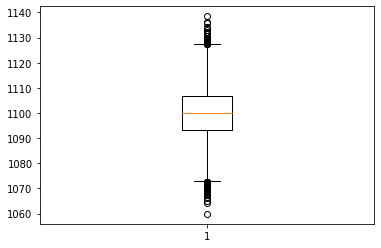

In [12]:
plt.boxplot(pairwise_diff(df.iloc[:,5])/1000)
plt.savefig("boxplot.png")

### Seasonality Decomposition

In [13]:
minute_ms = 60 * 1000
freq_minute = int(minute_ms / np.median(pairwise_diff(df.iloc[:,5])))
hour_ms = 60 * 60 * 1000
freq_hour = int(hour_ms / np.median(pairwise_diff(df.iloc[:,5])))
day_ms = 24 * 60 * 60 * 1000
freq_day = int(day_ms / np.median(pairwise_diff(df.iloc[:,5])))
week_ms = 7 * day_ms
freq_week = int(week_ms / np.median(pairwise_diff(df.iloc[:,5])))
month_ms = 30 * day_ms
freq_month = int(month_ms / np.median(pairwise_diff(df.iloc[:,5])))
year_ms = 365 * day_ms
freq_year = int(year_ms / np.median(pairwise_diff(df.iloc[:,5])))

In [14]:
freqs = np.array([freq_minute, freq_hour, freq_day, freq_week, freq_month, freq_year])
freqs_types = np.array(["minute", "hour", "day", "week", "month", "year"])
periods = df.shape[0] / (freqs + 1e-8)

freqs_filt = []
freqs_types_filt = []
total_time = df.iloc[-1,5] - df.iloc[0,5]
# if total_time <= minute_ms * 120:
#   freqs_filt.append(freq_minute)
#   freqs_types_filt.append("minute")
if total_time <= hour_ms * 48 and total_time >= hour_ms * 2:
  freqs_filt.append(freq_hour)
  freqs_types_filt.append("hour")
if total_time <= day_ms * 14 and total_time >= day_ms * 2:
  freqs_filt.append(freq_day)
  freqs_types_filt.append("day")
  freqs_filt.append(freq_hour)
  freqs_types_filt.append("hour")
if total_time <= week_ms * 8 and total_time >= week_ms * 2:
  freqs_filt.append(freq_week)
  freqs_types_filt.append("week")
  freqs_filt.append(freq_day)
  freqs_types_filt.append("day")
if total_time <= month_ms * 24 and total_time >= month_ms * 2:
  freqs_filt.append(freq_month)
  freqs_types_filt.append("month")
  freqs_filt.append(freq_week)
  freqs_types_filt.append("week")
if total_time >= year_ms * 2:
  freqs_filt.append(freq_year)
  freqs_types_filt.append("year")
  freqs_filt.append(freq_month)
  freqs_types_filt.append("month")

freqs_filt = np.array(freqs_filt)
freqs_types_filt = np.array(freqs_types_filt)
periods_filt = df.shape[0] / (freqs_filt + 1e-8)
# data_rolling_avg = df.iloc[:,2].rolling(int(df.shape[0]/10)).mean().dropna()
data_rolling_avg = df.iloc[:,2].rolling(int(df.shape[0]/500)).mean().dropna()

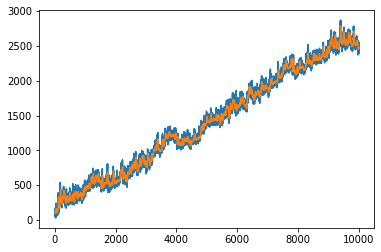

In [21]:
plt.plot(df["value"])
plt.plot(data_rolling_avg)

In [22]:
sds = []

for i in range(len(freqs_filt)):
  temp = data_rolling_avg
  for ii in range(len(sds)):
    temp -= sds[ii].seasonal
  sds.append(statsmodels.tsa.seasonal.seasonal_decompose(temp,freq=freqs_filt[i]))

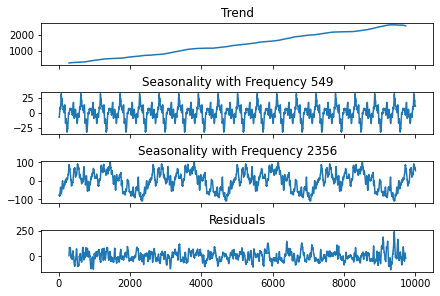

In [23]:
fig, axs = plt.subplots(nrows=len(freqs_filt)+2,sharex=True,constrained_layout=True)
axs[0].plot(sds[-1].trend)
axs[0].set_title("Trend")

for i in range(len(freqs_filt)-1,-1,-1):
  axs[len(freqs_filt)-i].plot(sds[i].seasonal)
  axs[len(freqs_filt)-i].set_title("Seasonality with Frequency " + str(freqs_filt[i]))

axs[-1].plot(sds[-1].resid)
axs[-1].set_title("Residuals")

fig.savefig("seasonality.png")

### Forecasting

In [42]:
lookback = 100
pred_length_lstm = 10
pred_length = 10000

#### Trend

In [45]:
y = np.array(sds[-1].trend).reshape(-1,1)
y[np.isnan(y)] = 0
X = np.arange(y.shape[0]).reshape(-1,1)

In [46]:
train_size = 0.7
X_train = X[:int(X.shape[0]*train_size)]
X_test = X[int(X.shape[0]*train_size):]
y_train = y[:int(y.shape[0]*train_size)]
y_test = y[int(y.shape[0]*train_size):]

In [47]:
degree=2
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

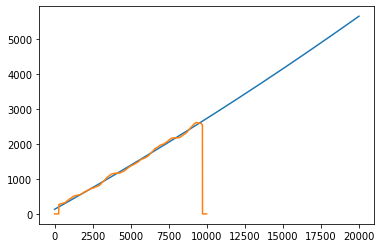

In [48]:
trend_pred = polyreg.predict(np.arange(y.shape[0] + pred_length).reshape(-1,1))

plt.plot(trend_pred)
plt.plot(y)

#### Resid

In [33]:
y = np.array(sds[-1].resid).reshape(-1,1)
y[np.isnan(y)] = 0

In [34]:
X_lstm = []
y_lstm = []

for i in range(y.shape[0]-lookback-pred_length_lstm):
  X_lstm.append(y[i:i+lookback].reshape(-1))
  y_lstm.append(y[i+lookback:i+lookback+pred_length_lstm].reshape(-1))

X_lstm = np.array(X_lstm)
X_lstm = X_lstm.reshape(X_lstm.shape[0],1,X_lstm.shape[1])
y_lstm = np.array(y_lstm)

In [35]:
train_size = 0.7
X_lstm_train = X_lstm[:int(X_lstm.shape[0]*train_size)]
X_lstm_test = X_lstm[int(X_lstm.shape[0]*train_size):]
y_lstm_train = y_lstm[:int(y_lstm.shape[0]*train_size)]
y_lstm_test = y_lstm[int(y_lstm.shape[0]*train_size):]

In [36]:
tf.random.set_seed(0)
np.random.seed(0)
model = TSModel(name="lstm", num_units=lookback, lookback=lookback, pred_length=pred_length_lstm)

Epoch 1/1000
54/54 [==============================] - 3s 18ms/step - loss: 34.7716 - mse: 1891.1458 - val_loss: 34.5793 - val_mse: 2368.2544
Epoch 2/1000
54/54 [==============================] - 0s 7ms/step - loss: 33.2962 - mse: 1759.2578 - val_loss: 33.0552 - val_mse: 2216.2175
Epoch 3/1000
54/54 [==============================] - 0s 8ms/step - loss: 31.4056 - mse: 1601.3677 - val_loss: 31.4036 - val_mse: 2063.9509
Epoch 4/1000
54/54 [==============================] - 0s 7ms/step - loss: 29.5407 - mse: 1457.3842 - val_loss: 29.9330 - val_mse: 1929.1415
Epoch 5/1000
54/54 [==============================] - 0s 8ms/step - loss: 27.8719 - mse: 1332.1053 - val_loss: 28.5626 - val_mse: 1808.3842
Epoch 6/1000
54/54 [==============================] - 0s 8ms/step - loss: 26.3176 - mse: 1221.3975 - val_loss: 27.2631 - val_mse: 1704.2800
Epoch 7/1000
54/54 [==============================] - 0s 8ms/step - loss: 24.9310 - mse: 1125.5769 - val_loss: 26.2176 - val_mse: 1615.2306
Epoch 8/1000
54/54 

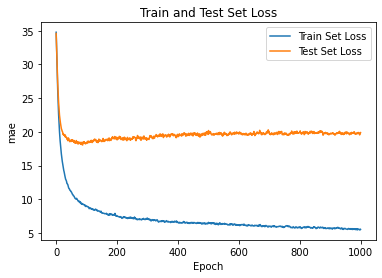

,Final Loss and Metrics
loss,5.534994
mse,56.981754
val_loss,19.889811
val_mse,835.692505


ValueError: ignored

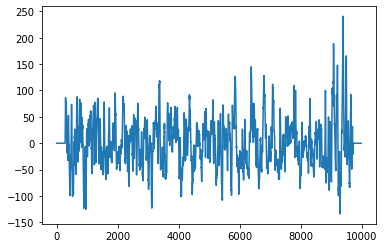

In [37]:
# 3 min, 30 sec
history = model.fit(X_lstm_train, y_lstm_train, X_lstm_test, y_lstm_test, epochs=1000, batch_size=128, loss="mae", metrics=["mse"])

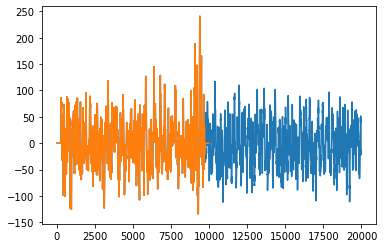

In [43]:
last_index = y.shape[0] - 1
while (y==0)[last_index]:
  last_index -= 1
resid_pred = y.tolist()[:last_index+1]

for i in range(math.ceil((y.shape[0]-last_index+pred_length)/pred_length_lstm)):
  pred = model.predict(np.array(resid_pred)[last_index+1-lookback:last_index+1].reshape(-1,1,lookback))
  resid_pred += [[i] for i in pred.tolist()[0]]
  last_index = len(resid_pred) - 1
resid_pred = np.array(resid_pred)[:y.shape[0]+pred_length]

plt.plot(resid_pred)
plt.plot(y)

#### Seasonal

In [44]:
seasonal_pred = np.array([sum([sds[i].seasonal.iloc[j%freqs_filt[i]] for i in range(len(sds))]) for j in range(y.shape[0]+pred_length)]).reshape(-1,1)

#### Putting them together!

In [49]:
pred = pd.DataFrame(resid_pred + trend_pred + seasonal_pred)
index = list(data_rolling_avg.index)
index = index + [index[-1] + i + 1 for i in range(pred_length)]
pred.index = index

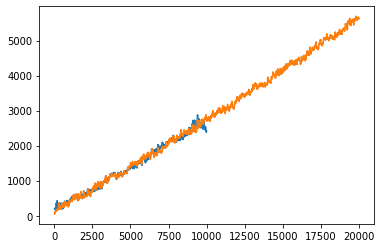

In [50]:
plt.plot(data_rolling_avg)
plt.plot(pred)
# plt.plot(df["value"])

In [184]:
pred

,0
999,194.418833
1000,194.772029
1001,195.167813
1002,195.580205
1003,195.962872
...,...
10995,2663.323648
10996,2663.523387
10997,2663.700324
10998,2663.915392


### Facebook Prophet

In [17]:
# !pip install pystan
# !pip install fbprophet

In [59]:
data_rolling_avg = df["value"].rolling(int(df.shape[0]/50)).mean().dropna()
ts = pd.DataFrame({"ds": df.iloc[data_rolling_avg.index, :]["time"], "y": data_rolling_avg})
ts.index = ts["ds"]
ts.head()

,ds,y
ds,,
2022-02-06 12:51:29.764020920,2022-02-06 12:51:29.764020920,209.465086
2022-02-06 13:09:54.507374762,2022-02-06 13:09:54.507374762,210.791811
2022-02-06 13:28:12.205724955,2022-02-06 13:28:12.205724955,211.609447
2022-02-06 13:46:40.695547104,2022-02-06 13:46:40.695547104,212.406156
2022-02-06 14:05:22.145012856,2022-02-06 14:05:22.145012856,213.201933


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


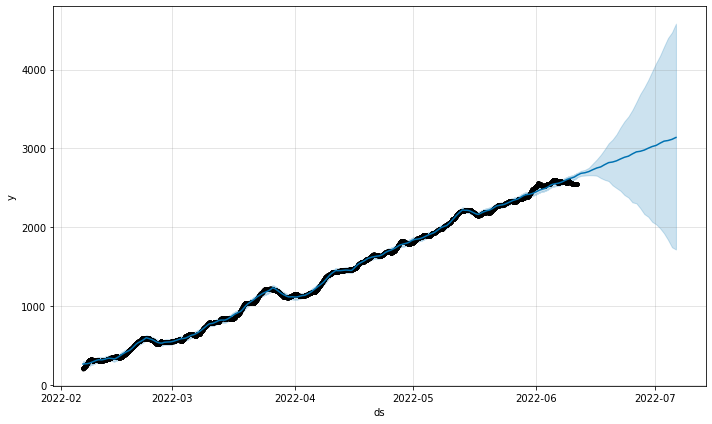

In [57]:
# instantiate the model and fit the timeseries
prophet = Prophet()
prophet.fit(ts)

# create a future data frame 
future = prophet.make_future_dataframe(periods=25)
forecast = prophet.predict(future)

# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

# plot
fig = prophet.plot(forecast)

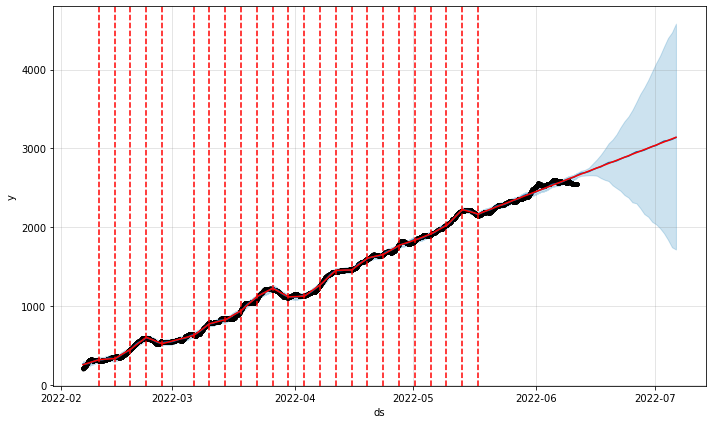

In [58]:
a = add_changepoints_to_plot(fig.gca(),prophet,forecast)
fig